In [1]:
import pandas as pd 
import numpy as np
from tabulate import tabulate
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
plt.style.use(plt.style.available[24])
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the xtick labels
plt.rc('ytick', labelsize=12)     # fontsize of the ytick labels (also applies to colorbar)
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title
plt.rc('axes', titlesize=14)
plt.rc('lines', linewidth=2)     # line width
plt.rc('figure', figsize=(6, 5)) # figure size
plt.rc('axes', axisbelow=True)

In [2]:
models = ['POLY', 'SVGP', 'NN']
betas = [0, 0.25, 0.5, 0.75, 1]
cutoffs = [1, 1.5]
X_grid = np.load('results/Xgrid.npy')
y_grid = np.load('results/Ygrid.npy')
data = np.zeros((len(models), len(betas), len(cutoffs), X_grid.shape[0], X_grid.shape[1]))
for i, model in enumerate(models):
    for j, beta in enumerate(betas):
        for k, cutoff in enumerate(cutoffs):
            data[i, j, k] = np.load(f'results/{model}_beta={beta}_cutoff={cutoff}.npy')

X_grid_fuchs = np.load('results/FUCHS_Xgrid.npy')[30:]
y_grid_fuchs = np.load('results/FUCHS_Ygrid.npy')[30:]
fuchs_data = np.zeros((len(betas), len(cutoffs), X_grid_fuchs.shape[0], X_grid_fuchs.shape[1]))
for j, beta in enumerate(betas):
    for k, cutoff in enumerate(cutoffs):
        fuchs_data[j, k] = np.load(f'results/FUCHS_beta={beta}_cutoff={cutoff}.npy')[30:]
print(fuchs_data.shape)
print(y_grid_fuchs.shape)

(5, 2, 31, 10)
(31, 10)


In [3]:
opt_indices = np.zeros((len(models), len(betas), len(cutoffs)), dtype=tuple)
opt_fuchs_indices = np.empty((len(betas), len(cutoffs)), dtype=tuple)
for i, model in enumerate(models):
    for j, beta in enumerate(betas):
        for k, cutoff in enumerate(cutoffs):
            current_opt = np.unravel_index(np.argmin(data[i, j, k]), data[i, j, k].shape)
            opt_indices[i, j, k] = current_opt
for j, beta in enumerate(betas):
    for k, cutoff in enumerate(cutoffs):
        current_opt = np.unravel_index(np.argmin(fuchs_data[j, k]), fuchs_data[j, k].shape)
        print(f'opt: {current_opt}, coordinate: ({X_grid_fuchs[current_opt]}, {y_grid_fuchs[current_opt]}), val: {fuchs_data[j, k][current_opt]}')
        opt_fuchs_indices[j, k] = current_opt

opt: (11, 0), coordinate: (0.5, 11.0), val: -2.8912884644523644
opt: (11, 0), coordinate: (0.5, 11.0), val: -2.8912884644523644
opt: (10, 0), coordinate: (0.5, 9.999999999999996), val: -1.8907195669350094
opt: (10, 0), coordinate: (0.5, 9.999999999999996), val: -2.0157195669350094
opt: (8, 0), coordinate: (0.5, 7.999999999999995), val: -0.8935229916199308
opt: (8, 0), coordinate: (0.5, 7.999999999999995), val: -1.1435229916199308
opt: (2, 6), coordinate: (3.5, 1.9999999999999978), val: -0.3016194655973893
opt: (0, 1), coordinate: (1.0, -3.3881317890172014e-15), val: -0.5039923097762152
opt: (17, 7), coordinate: (4.0, 16.999999999999996), val: 0.000401070056359476
opt: (16, 3), coordinate: (2.0, 16.0), val: 0.004120170235849985


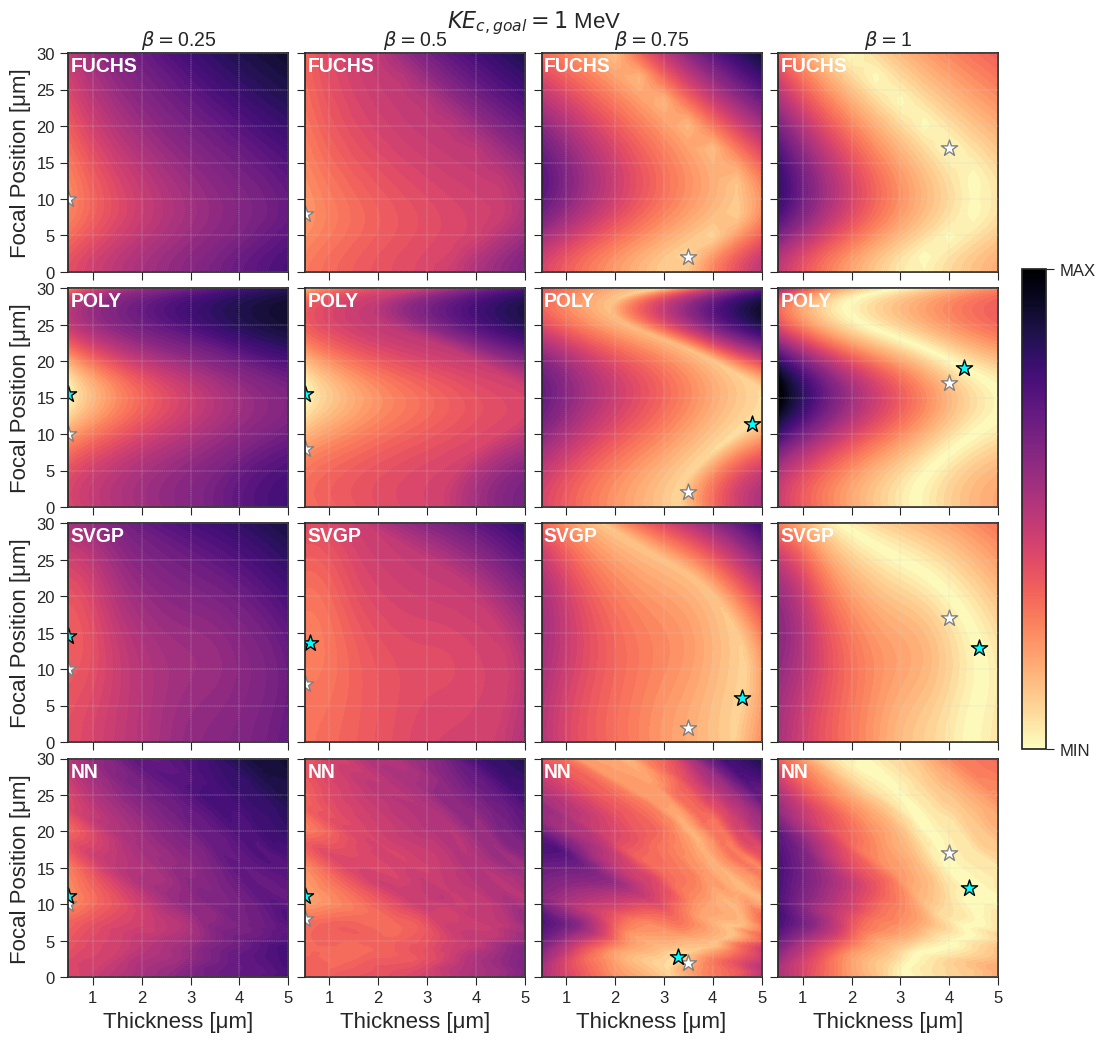

In [10]:
cutoff_idx = 0
cmap='magma_r'
spacing = 0.075
xticks = np.arange(1, 5.1, 1)
yticks = np.arange(0, 31, 5)
levels = [np.linspace(-3.75, 0, 51), 
            np.linspace(-2.5, 0, 51), 
            np.linspace(-1.2, 0.2, 51), 
            np.linspace(-0.35, 0.3, 51), 
            np.linspace(0, 1.38, 51)]
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for j, beta in enumerate(betas[1:]):
    axs[0, j].contourf(X_grid_fuchs, y_grid_fuchs, fuchs_data[j+1, cutoff_idx], cmap=cmap, levels=levels[j+1])
    axs[0, j].text(0.55, 27.5, 'FUCHS', fontsize=14, color='white', fontweight='bold')
    axs[0, j].set_title(r'$\beta = $' + str(beta))
    axs[0, j].set_ylim(0, 30)
    axs[0, j].scatter(X_grid_fuchs[opt_fuchs_indices[j+1, cutoff_idx]], y_grid_fuchs[opt_fuchs_indices[j+1, cutoff_idx]], marker='*', color='white', s=150, edgecolors='gray')

norm = Normalize(vmin=np.min(levels[1]), vmax=np.max(levels[1]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.75, 0.3, 0.2, 0.4])
cbar = fig.colorbar(sm, ax=cbar_ax)
cbar.set_ticks([np.min(levels[1]), np.max(levels[1])])
cbar.set_ticklabels(['MIN', 'MAX'])
cbar_ax.axis('off')
#cbar.outline.set_visible(False)
axs[0, 0].set_ylabel('Focal Position [μm]')
for i in range(4):
    for j in range(4):
        if j > 0:
            axs[i, j].set_yticklabels([])
        axs[i, j].grid(True, color='lightgray', linestyle='dashed', linewidth=0.25)
        axs[i, j].set_axisbelow(False)
        axs[i, j].set_xticks(xticks)
        axs[i, j].set_yticks(yticks)
for i, model in enumerate(models):
    for j, beta in enumerate(betas[1:]):
        axs[i+1, j].contourf(X_grid, y_grid, data[i, j+1, cutoff_idx], cmap=cmap, levels=levels[j+1])
        axs[i+1, j].scatter(X_grid_fuchs[opt_fuchs_indices[j+1, cutoff_idx]], y_grid_fuchs[opt_fuchs_indices[j+1, cutoff_idx]], marker='*', color='white', s=150, edgecolors='gray')
        axs[i+1, j].scatter(X_grid[opt_indices[i, j+1, cutoff_idx]], y_grid[opt_indices[i, j+1, cutoff_idx]], marker='*', color='cyan', s=150, edgecolors='black')
        axs[i+1, j].text(0.55, 27.5, model, fontsize=14, color='white', fontweight='bold')
        axs[i, j].set_xticklabels([])
        axs[3, j].set_xlabel('Thickness [μm]')
    axs[i+1, 0].set_ylabel('Focal Position [μm]')

axs[0, 0].text(8.25, 33.5, '$KE_{c, goal} = 1$ MeV', fontsize=16)

for j in range(4):
    axs[3, j].set_xticks(np.arange(1, 5.1, 1))
fig.subplots_adjust(wspace=spacing, hspace=spacing)
fig.savefig('plots/obj_fn_model_cutoff=1.eps', format='eps', bbox_inches='tight')

In [5]:
dist = np.zeros((3, 5))
for i in range(3):
    print(models[i])
    for j in range(5):
        x1 = np.array((X_grid_fuchs[opt_fuchs_indices[j, cutoff_idx]], y_grid_fuchs[opt_fuchs_indices[j, cutoff_idx]]))
        x2 = np.array((X_grid[opt_indices[i, j, cutoff_idx]], y_grid[opt_indices[i, j, cutoff_idx]]))
        dist[i, j] = np.linalg.norm(x1-x2)
print(data.shape, fuchs_data.shape)
print(dist)

POLY
SVGP
NN
(3, 5, 2, 301, 46) (5, 2, 31, 10)
[[4.5        5.5        7.5        9.48946785 2.12132034]
 [3.5        4.5        5.60089279 4.1484937  4.14366987]
 [0.4        1.2        3.1        0.82462113 4.71699057]]


In [6]:
print(X_grid_fuchs.shape, X_grid[0:301:10,0:46:5].shape, y_grid_fuchs.shape, y_grid[0:301:10,0:46:5].shape)

(31, 10) (31, 10) (31, 10) (31, 10)


In [12]:
i = 0
j = 0
ssims = np.zeros((3, 5))
rmses = np.zeros((3, 5))
mapes = np.zeros((3, 5))
for j in range(5):
    fuchs_data_j = fuchs_data[j, cutoff_idx]
    data_range = np.max(fuchs_data_j) - np.min(fuchs_data_j)
    for i in range(3):
        ssims[i, j] = ssim(fuchs_data_j, data[i, j, cutoff_idx, 0:301:10, 0:46:5], data_range=1)
        rmses[i, j] = np.sqrt(mse(fuchs_data_j, data[i, j, cutoff_idx, 0:301:10, 0:46:5]))
        mapes[i, j] = mape(fuchs_data_j, data[i, j, cutoff_idx, 0:301:10, 0:46:5]) * 100

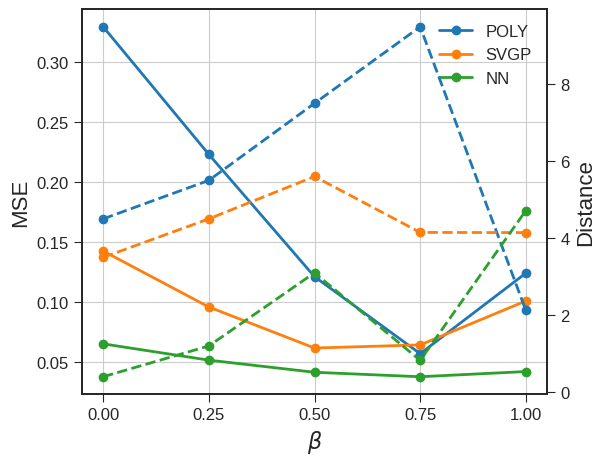

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(betas, rmses[[0, 1, 2], :].T, marker='o')
ax2 = ax.twinx()
ax2.plot(betas, dist[[0, 1, 2], :].T, marker='o', linestyle='--')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('MSE')
ax2.set_ylabel('Distance')
ax.legend(models)
ax.set_xticks(betas)
ax.grid(True)

In [15]:
col_headers = ['0', '0.25', '0.5', '0.75', '1']
row_headers = ['POLY', 'SVGP', 'NN']
rmses_with_headers = np.vstack(([""] + col_headers, np.column_stack((row_headers, rmses))))
mapes_with_headers = np.vstack(([""] + col_headers, np.column_stack((row_headers, mapes))))
dist_with_headers = np.vstack(([""] + col_headers, np.column_stack((row_headers, dist))))
print(tabulate(mapes_with_headers, tablefmt='latex'))
print(tabulate(rmses_with_headers, tablefmt='latex'))
print(tabulate(dist_with_headers, tablefmt='latex'))

\begin{tabular}{lrrrrr}
\hline
      &  0       &  0.25    &  0.5     &   0.75  &   1      \\
 POLY & 16.6963  & 17.5855  & 28.6252  & 120.111 & 252.393  \\
 SVGP &  9.11098 & 10.0261  & 19.3923  & 287.782 & 133.049  \\
 NN   &  3.74506 &  4.29386 &  7.62795 & 178.331 &  61.6188 \\
\hline
\end{tabular}
\begin{tabular}{lrrrrr}
\hline
      & 0         & 0.25      & 0.5       & 0.75      & 1         \\
 POLY & 0.32914   & 0.222994  & 0.121268  & 0.0572098 & 0.124205  \\
 SVGP & 0.142606  & 0.0960359 & 0.0618957 & 0.0645051 & 0.101056  \\
 NN   & 0.0653863 & 0.051823  & 0.0417383 & 0.0380101 & 0.0423517 \\
\hline
\end{tabular}
\begin{tabular}{lrrrrr}
\hline
      & 0   & 0.25 & 0.5     & 0.75     & 1       \\
 POLY & 4.5 & 5.5  & 7.5     & 9.48947  & 2.12132 \\
 SVGP & 3.5 & 4.5  & 5.60089 & 4.14849  & 4.14367 \\
 NN   & 0.4 & 1.2  & 3.1     & 0.824621 & 4.71699 \\
\hline
\end{tabular}


In [14]:
mses

array([[0.10833324, 0.04972613, 0.01470604, 0.00327297, 0.01542692],
       [0.02033634, 0.00922289, 0.00383108, 0.00416091, 0.01021239],
       [0.00427537, 0.00268562, 0.00174209, 0.00144477, 0.00179367]])